In [1]:
import os, argparse, pickle, librosa
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import torch
from glob import glob
from eval_utils import *
import models
import IPython.display as ipd
from tqdm import tqdm

In [2]:
args = argparse.ArgumentParser()
args.add_argument('--gpus', type=str, default='0')
args.add_argument('--batch', type=int, default=1)
args.add_argument('--len', type=int, default=200)
args.add_argument('--b', type=int, default=200)
args.add_argument('--latency', type=int, default=5)
args.add_argument('--mode', type=str, default='sj_S')
args.add_argument('--model', type=str, default='CombineAutoencoder')
args.add_argument('--weight', action='store_true')
args.add_argument('--ema', action='store_true')
args.add_argument('--relu', action='store_true')
args.add_argument('--future', action='store_true')
args.add_argument('--feature', type=str, default='wav', choices=['wav', 'mel'])
args.add_argument('--diff', action='store_true')
config = args.parse_known_args(['--diff', '--future'])[0]

In [3]:
SR = 8192
WINDOW_SIZE = 500 # us
data_length = config.len
BATCH_SIZE = config.batch
K, m = 8, 8
ls = 128

In [ ]:

class makeDataset(Dataset):
    def __init__(self, accel, sound, config, train=True):
        self.config = config
        self.takebeforetime = config.b
        self.data_length = config.len
        if self.takebeforetime % self.data_length != 0:
            raise ValueError(f'takebeforetime must be the multiple of data_length, {takebeforetime}')
        if config.feature == 'mel':
            if type(accel) == list:
                melaccel = torch.from_numpy(np.concatenate(accel)).type(torch.float)
                tomel = torchaudio.transforms.MelSpectrogram(sample_rate=8192, n_fft=config.b + config.len, hop_length=config.b, n_mels=config.n_mels)
                self.accel = torch.cat([tomel(melaccel[:,i]).unsqueeze(0) for i in range(melaccel.shape[-1])]).type(torch.double).transpose(0,2)
            if type(sound) == list:
                self.sound = data_spread(sound, self.data_length)

        elif config.feature == 'wav':
            self.accel = data_spread(accel, self.data_length)
            self.sound = data_spread(sound, self.data_length)
        else:
            raise ValueError(f'invalid feature {config.feature}')
        self.perm = torch.arange(len(self.accel))
        if train:
            self.shuffle()
        if len(self.accel) < (self.takebeforetime // self.data_length) + 1:
            raise ValueError(f'Dataset is too small, {len(accel)}')
    
    def shuffle(self):
        self.perm = torch.randperm(len(self.accel))

    def __len__(self):
        return len(self.accel)

    def __getitem__(self, idx):
        if self.config.feature == 'wav':
            if self.perm[idx] - (self.takebeforetime // self.data_length) < 0:
                return torch.cat([torch.zeros((((self.takebeforetime // self.data_length) - self.perm[idx]) * self.accel.size(1),) + self.accel.shape[2:],dtype=self.accel.dtype,device=self.accel.device),self.accel[self.perm[idx]]]).transpose(0,1), self.sound[self.perm[idx]]
            return torch.reshape(self.accel[self.perm[idx] - (self.takebeforetime // self.data_length): self.perm[idx] + 1], (-1, self.accel.size(-1))).transpose(0,1), self.sound[self.perm[idx]]
        elif self.config.feature == 'mel':
            if self.perm[idx] - (self.takebeforetime // self.data_length) < 0:
                return torch.cat([torch.zeros((((self.takebeforetime // self.data_length) - self.perm[idx]) * self.accel.size(1),) + self.accel.shape[2:],dtype=self.accel.dtype,device=self.accel.device),self.accel[self.perm[idx]]]).transpose(0,1), self.sound[self.perm[idx]]
            return torch.reshape(self.accel[self.perm[idx] - (self.takebeforetime // self.data_length): self.perm[idx] + 1], (-1, self.accel.size(-1))).transpose(0,1), self.sound[self.perm[idx]]
        

In [21]:
ABSpath = '/home/skuser/'
path = os.path.join(ABSpath, 'ai_model/pytorch/test_model')
data_path = os.path.join(ABSpath,'datasets/hyundai')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
accel_raw_data = pickle.load(open(os.path.join(data_path,'stationary_accel_data.pickle'),'rb'))
sound_raw_data = pickle.load(open(os.path.join(data_path,'stationary_sound_data.pickle'),'rb'))
transfer_f = np.array(pickle.load(open(os.path.join(data_path,'transfer_f.pickle'),'rb')))
transfer_f = torch.from_numpy(transfer_f).to(device)
transfer_f.requires_grad = False

dataset = makeDataset(accel_raw_data, sound_raw_data, config, False)
name = f'CombineAutoencoder_sj_S_b{config.b}_d{config.len}_lat{config.latency}_adam_0.001_decay0.7071_featurewav_future_diff/*'
# name = 'FCAutoencoder_sj_S_40_40_adam_0.001_decay0.7071/*'
modelsavepath = sorted(glob(os.path.join(path, 'model_save/'+name)), key=lambda x: float(os.path.basename(x).split('.pt')[0].split('_')[-1]))[0]
model = getattr(models, config.model)(dataset[0][0].shape[1:], dataset[0][1].shape[1:], dataset[0][0].shape[0], dataset[0][1].shape[0], config).to(device)

In [7]:
print(modelsavepath)
model.load_state_dict(torch.load(modelsavepath)['model'])

/home/skuser/ai_model/pytorch/test_model/model_save/CombineAutoencoder_sj_S_b200_d200_lat5_adam_0.001_decay0.7071_featurewav_future_difftest/6_0.928.pt


<All keys matched successfully>

In [9]:
dataset_generator = DataLoader(dataset, batch_size=32, shuffle=False)
data_res, sound_res = [], []
model.eval()
with torch.no_grad():
    for data, sound in tqdm(dataset_generator):
#         data_res.append(conv_with_S(model(data.to(device)), S_data=transfer_f, device=device, config=config).cpu()[:,0,:])
        data_res.append(conv_with_S(model(data.to(device)), S_data=transfer_f, device=device, config=config).cpu())
        sound_res.append(sound)

100%|██████████| 3288/3288 [00:51<00:00, 63.86it/s] 


In [10]:
from time import time
with torch.no_grad():
    for data, sound in dataset_generator:
        s = time()
        model(data.to(device))
        print(time() - s)
        break

0.0017631053924560547


In [11]:
data_res = torch.cat(data_res)
sound_res = torch.cat(sound_res)

In [12]:
data_res = torch.reshape(data_res, (-1,data_res.size(-1)))
sound_res = torch.reshape(sound_res, (-1,data_res.size(-1)))

<Figure size 432x288 with 0 Axes>

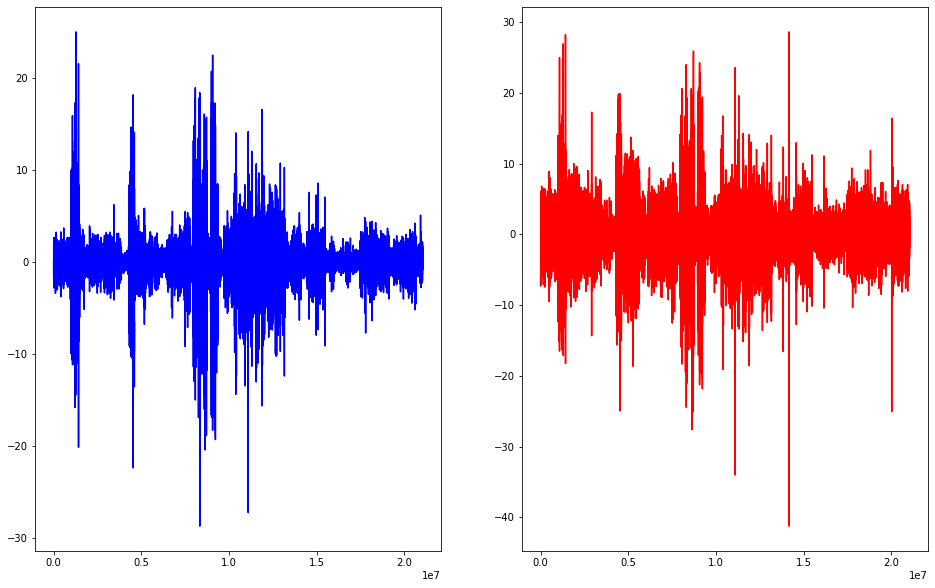

In [13]:
fig = plt.figure()
fig, ax_lst = plt.subplots(1, 2, figsize=(16,10))
ax_lst[0].plot(np.arange(data_res.size(0)), data_res[:,0], color="blue")
ax_lst[1].plot(np.arange(sound_res.size(0)), sound_res[:,0], color="red")
# ax_lst[1].plot(np.arange(data_res.size(0)), data_res[:,1])
# ax_lst[0].plot(np.arange(sound_res.size(0)), data_res[:,1])

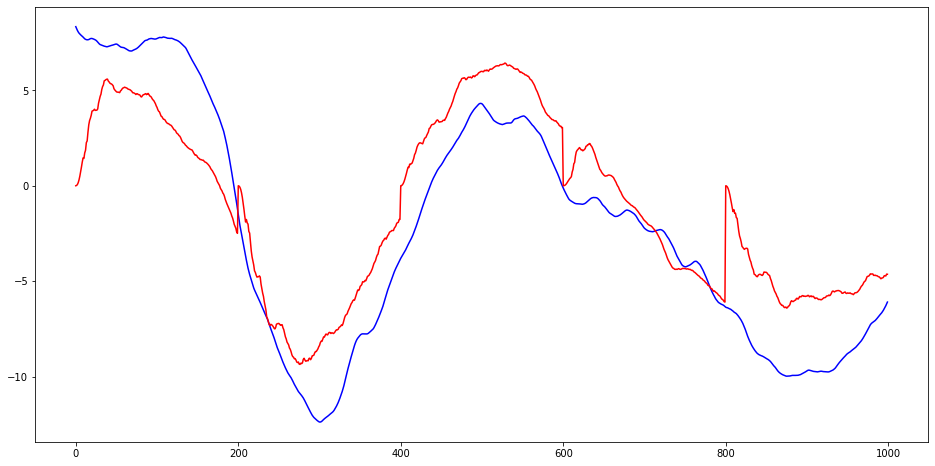

In [14]:
start = 1000000
end = 1001000
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot()
ax.plot(sound_res[start:end,0], color="blue")
ax.plot(data_res[start:end,0], color="red")
# self.writer.add_figure("Train/Plot", fig, data_res.size(0))
plt.show(fig)

In [15]:
# smoo = ema(data_res, n=40)

In [16]:
# fig=plt.figure(figsize=(16,8))
# ax = fig.add_subplot()
# ax.plot(smoo[start:end,1], color="red")
# ax.plot(sound_res[start:end,1], color="blue")
# plt.show(fig)

In [17]:
dBA_metric(data_res, sound_res, False)

-13.976152651113475

In [ ]:
write_wav(sound_res[1000000:1100000,0] - data_res[1000000:1100000,0], name='sound').shape

In [ ]:
ipd.Audio('sound.wav',normalize=False)

In [ ]:
ipd.Audio('smooth.wav',normalize=False) # load a local WAV file